# curating  data for an area of interest

- easy to do a for a single AOI, just update and re-run script for different AOI.
Inefficient as we start wanting to look at more.
- Update code relative to `aoi_calculations.ipynb` to try to keep things grouped
by region


# Import general packages


In [ ]:
import stitches as stitches


import pandas as pd
import pkg_resources
import xarray as xr
import numpy as np
import seaborn as sns

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")
# For help with plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)

# import packages for spatial masking

In [2]:
import geopandas as gpd
# Spatial subsetting of netcdf files:
import regionmask

#  Set up time slices and area of interest (AOI) to focus on

- require ensemble average PR values over the ref period and comparison period
for an area of interest
- Do spatial aggregation for each ensemble member, take the time average in the
time window, calculate average across ensemble members

In [3]:
# Time slices
ref_start = '1995-01-01'
ref_end =  '2014-12-31'

comp_start = '2015-01-01'
comp_end =  '2099-12-31'

window_length = 20

In [4]:
# AOI
# working off https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/subset-netcdf4-climate-data-spatially-aoi/

# # physical land polygon files:
# url =  (    "https://naturalearth.s3.amazonaws.com/"
# "10m_physical/ne_10m_land.zip")

# # country URL
# url =  (    "https://naturalearth.s3.amazonaws.com/"
#             "10m_cultural/ne_10m_admin_0_countries.zip")

# # state/province URL
# url =  (    "https://naturalearth.s3.amazonaws.com/"
#             "10m_cultural/ne_10m_admin_1_states_provinces.zip")

# IPCC ar6 reference regions - including ocean regions
# actually have to download locally from
# https://github.com/IPCC-WG1/Atlas/blob/main/reference-regions/IPCC-WGI-reference-regions-v4_shapefile.zip
url =  (   'IPCC-WGI-reference-regions-v4_shapefile.zip')

land_main_gdf = gpd.read_file(url)
land_main_gdf.head()

,Continent,Type,Name,Acronym,geometry
0,POLAR,Land,Greenland/Iceland,GIC,"POLYGON ((-10.00000 62.00000, -10.43750 62.000..."
1,NORTH-AMERICA,Land,N.W.North-America,NWN,"POLYGON ((-105.00000 50.00000, -105.43860 50.0..."
2,NORTH-AMERICA,Land,N.E.North-America,NEN,"POLYGON ((-50.00000 50.00000, -50.44000 50.000..."
3,NORTH-AMERICA,Land,W.North-America,WNA,"POLYGON ((-130.00000 50.00000, -129.56140 50.0..."
4,NORTH-AMERICA,Land,C.North-America,CNA,"POLYGON ((-90.00000 50.00000, -90.00000 49.561..."


['GIC' 'NWN' 'NEN' 'WNA' 'CNA' 'ENA' 'NCA' 'SCA' 'CAR' 'NWS' 'NSA' 'NES'
 'SAM' 'SWS' 'SES' 'SSA' 'NEU' 'WCE' 'EEU' 'MED' 'SAH' 'WAF' 'CAF' 'NEAF'
 'SEAF' 'WSAF' 'ESAF' 'MDG' 'RAR' 'WSB' 'ESB' 'RFE' 'WCA' 'ECA' 'TIB'
 'EAS' 'ARP' 'SAS' 'SEA' 'NAU' 'CAU' 'EAU' 'SAU' 'NZ' 'EAN' 'WAN' 'ARO'
 'NPO' 'EPO' 'SPO' 'NAO' 'EAO' 'SAO' 'ARS' 'BOB' 'EIO' 'SIO' 'SOO']


<AxesSubplot:>

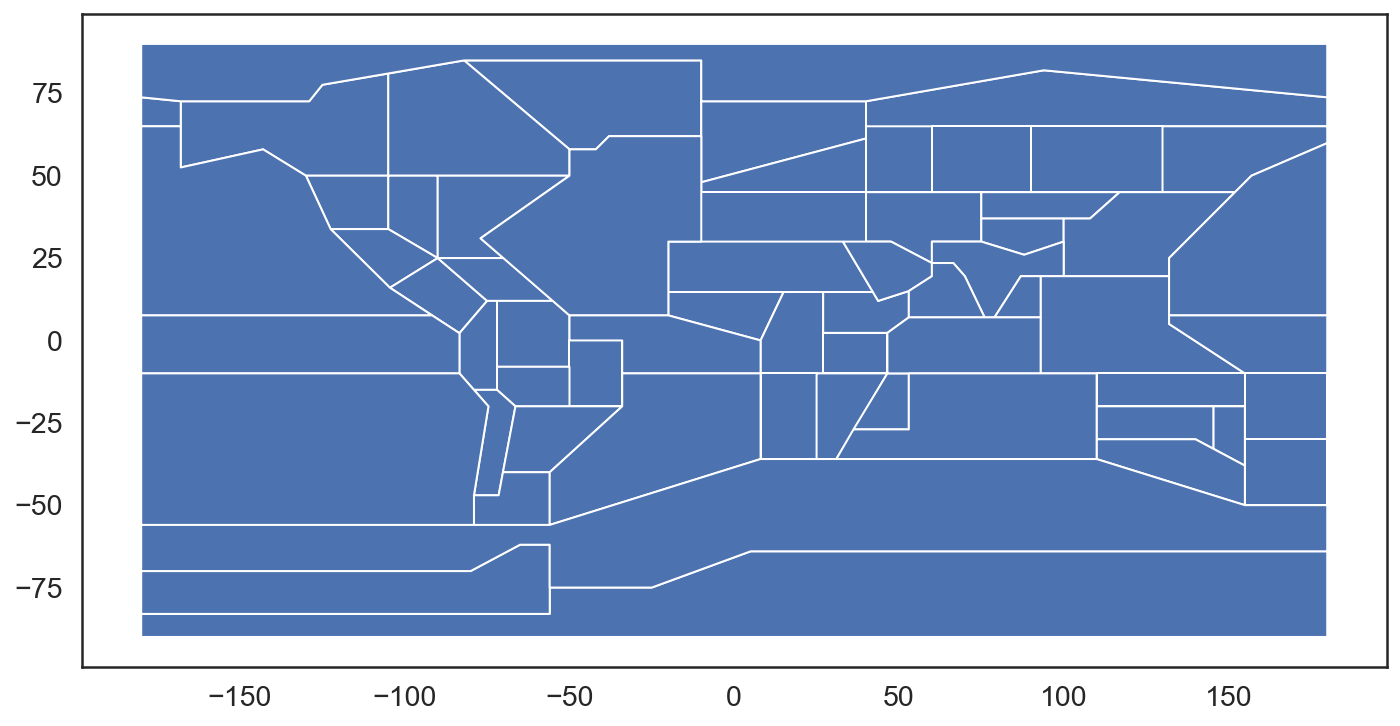

In [5]:
IPCC_names  = land_main_gdf['Acronym'].unique()
print(IPCC_names)
land_main_gdf.plot()


# specify ESMs, variables, experiments

In [6]:
# The CMIP6 ESM we want to emulate and the variables we want to
# emulate
# NOTE IPSL and GFDL submitted results under grids labeled not `gn` so they
# are not included in the stitches patches data. To pull their ESMs, we have to
# source the pangeo table directly from pangeo and reshape it instead of using
# the stitches package data.


esm = ['CAMS-CSM1-0', 'MIROC6', 'GFDL-ESM4', 'FGOALS-g3',
'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'CESM2-WACCM',
'UKESM1-0-LL',
'CanESM5']

vars1 = ['pr']

exps = ['historical','ssp126', 'ssp245', 'ssp370',  'ssp585',
        'ssp460', 'ssp119',   'ssp434', 'ssp534-over']

# Pull pangeo dataframe with netcdf addresses for above

In [7]:
# pangeo table of ESMs for reference
pangeo_data = stitches.fx_pangeo.fetch_pangeo_table()

pangeo_data = pangeo_data[(pangeo_data['source_id'].isin(esm)) &
                           (pangeo_data['variable_id'].isin(vars1)) &(pangeo_data['table_id'] == 'Amon')&
                           ((pangeo_data['experiment_id'].isin(exps)))].copy()

# reshape to look like package data but with the ESMs we want to include
pangeo_data = pangeo_data[["source_id", "experiment_id", "member_id", "variable_id", "grid_label",
                                                        "zstore", "table_id"]].copy()
pangeo_data = pangeo_data.rename(columns={"source_id": "model", "experiment_id": "experiment",
                                                "member_id": "ensemble", "variable_id": "variable",
                                                "zstore": "zstore", "table_id": "domain"}).reset_index(drop = True).copy()

 # keep only p1 runs:
# UK model only does f2 runs for some reason
ukesm_data =  pangeo_data[pangeo_data['model'].str.contains('UKESM')].copy()
ukesm_data = ukesm_data[ukesm_data['ensemble'].str.contains('i1p1f2')].copy()

# everyone else does f1 runs
pangeo_data = pangeo_data[pangeo_data['ensemble'].str.contains('i1p1f1')].copy()

# combine UKESM with other models
pangeo_data = pd.concat([pangeo_data, ukesm_data]).reset_index(drop=True).copy()


# loop over files and do calculations

In [ ]:
aoi = land_main_gdf.reset_index(drop=True).copy()


In [ ]:
varname = vars1[0]

holder = pd.DataFrame()
timeseries_holder = pd.DataFrame()

for esmname in esm[0:1]:
  for exp in exps[0:1]:

    print(esmname)
    print(exp)
    df_ens_avg = 0

    filelist = pangeo_data[(pangeo_data['model'] ==esmname) & (pangeo_data['experiment'] == exp)].copy()

    if filelist.empty:
        print('no ensemble members for this exp')
        df_shaped =  pd.DataFrame({'esm':[esmname]})
        df_shaped['experiment'] = exp
        df_shaped['ens_avg']= -999
        df_shaped['ens_avg_iasd'] = -999
        df_shaped['ens_avg_sd'] = -999
        # end if no files for experiment

    if not filelist.empty:
        df_sum = 0
        df_iav_sum = 0
        df_sd_sum = 0
        n_good_files = 0

        for i in [0]: # range(len(filelist)):
            print(i)

            # Load data:
            x = stitches.fx_pangeo.fetch_nc(filelist.iloc[i].zstore)
            x = x.sortby('time').copy()

            # If it's the first ensemble member, set up the mask
            if (i==0):
                aoi_mask = regionmask.mask_3D_geopandas(aoi,
                                                        x.lon,
                                                        x.lat)
                # end if i==0 set up aoi_mask

            # mask the file
            x = x.where(aoi_mask).copy()

            # If the experiment is historical, further slice to reference years.
            # Otherwise, slice to comparison years:
            if (exp == 'historical'):
                window_length = 20
                if(esmname == 'UKESM1-0-LL'):
                    x = x.sel(time=slice(ref_start, '2014-12-30')).copy()
                if(esmname != 'UKESM1-0-LL'):
                    x = x.sel(time=slice(ref_start, ref_end)).copy()

            if(exp!='historical'):
                window_length = 85
                if(esmname == 'UKESM1-0-LL'):
                    x = x.sel(time=slice(comp_start, '2099-12-30')).copy()
                if(esmname != 'UKESM1-0-LL'):
                    x = x.sel(time=slice(comp_start, comp_end)).copy()

                # end if checks for time slicing

            # Check if there are the correct number of time steps in this
            # sliced data:
            # Very rough QC for checking complete netcdfs and assumes
            # comparison window and reference window same length.
            if (len(x.time) >= 12*window_length):
                # coerce to DF so we can properly lat weight to do spatial aggregation:
                x1 = x[varname].to_dataframe().dropna().reset_index().reset_index(drop=True).copy()

In [ ]:
varname = vars1[0]

holder = pd.DataFrame()
timeseries_holder = pd.DataFrame()

for esmname in esm:
  for exp in exps:

    print(esmname)
    print(exp)
    df_ens_avg = 0

    filelist = pangeo_data[(pangeo_data['model'] ==esmname) & (pangeo_data['experiment'] == exp)].copy()

    if filelist.empty:
        print('no ensemble members for this exp')
        df_shaped =  pd.DataFrame({'esm':[esmname]})
        df_shaped['experiment'] = exp
        df_shaped['ens_avg']= -999
        df_shaped['ens_avg_iasd'] = -999
        df_shaped['ens_avg_sd'] = -999
        # end if no files for experiment

    if not filelist.empty:
        df_sum = 0
        df_iav_sum = 0
        df_sd_sum = 0
        n_good_files = 0

        for i in range(len(filelist)):
            print(i)

            # Load data:
            x = stitches.fx_pangeo.fetch_nc(filelist.iloc[i].zstore)
            x = x.sortby('time').copy()

            # If it's the first ensemble member, set up the mask
            if (i==0):
                aoi_mask = regionmask.mask_3D_geopandas(aoi,
                                                        x.lon,
                                                        x.lat)
                # end if i==0 set up aoi_mask

            # mask the file
            x = x.sel(lon = slice(aoi_lon[0], aoi_lon[1]),
                      lat = slice(aoi_lat[0], aoi_lat[1])).where(aoi_mask).copy()

            # If the experiment is historical, further slice to reference years.
            # Otherwise, slice to comparison years:
            if (exp == 'historical'):
                if(esmname == 'UKESM1-0-LL'):
                    x = x.sel(time=slice(ref_start, '2014-12-30')).copy()
                if(esmname != 'UKESM1-0-LL'):
                    x = x.sel(time=slice(ref_start, ref_end)).copy()

            if(exp!='historical'):
                if(esmname == 'UKESM1-0-LL'):
                    x = x.sel(time=slice(comp_start, '2099-12-30')).copy()
                if(esmname != 'UKESM1-0-LL'):
                    x = x.sel(time=slice(comp_start, comp_end)).copy()

                # end if checks for time slicing

            # Check if there are the correct number of time steps in this
            # sliced data:
            # Very rough QC for checking complete netcdfs and assumes
            # comparison window and reference window same length.
            if (len(x.time) >= 12*window_length):
                # coerce to DF so we can properly lat weight to do spatial aggregation:
                x1 = x[varname].to_dataframe().dropna().reset_index().drop(['region'],
                                                                     axis=1).reset_index(drop=True).copy()

                # spatial aggregation:
                monthly_aoi = pd.DataFrame()
                for name, group in x1.groupby('time'):
                    lat = group['lat']
                    area = np.cos(np.deg2rad(lat))
                    df = pd.DataFrame({'time': group['time'].drop_duplicates()})
                    df['aggregate'] = sum(area * group[varname])/sum(area)
                    monthly_aoi = pd.concat([monthly_aoi, df]).reset_index(drop=True).copy()
                    del(df)
                    del(area)
                    del(lat)
                    # end for loop over months to do spatial disaggregation

                # time average for this ensemble member:
                monthly_aoi['year'] = monthly_aoi['time'].apply(lambda x: x.year).copy()
                annual_aoi = pd.DataFrame({'year': monthly_aoi['year'].drop_duplicates(),
                                           'ann_agg':monthly_aoi.groupby('year')['aggregate'].mean().values}).reset_index(drop=True).copy()
                aoi_val = annual_aoi['ann_agg'].mean()
                aoi_sd = annual_aoi['ann_agg'].std()
                aoi_ia_sd = annual_aoi.diff()['ann_agg'].std()

                annual_aoi['esm'] = filelist.iloc[i].model
                annual_aoi['experiment'] =  filelist.iloc[i].experiment
                annual_aoi['ensemble'] = filelist.iloc[i].ensemble
                annual_aoi['variable'] = filelist.iloc[i].variable
                timeseries_holder = pd.concat([timeseries_holder, annual_aoi]).reset_index(drop=True).copy()
                del(annual_aoi)

                # and add it to the running sum for the ensemble members
                df_sum = (aoi_val  + df_sum)
                df_iav_sum = (aoi_ia_sd + df_iav_sum)
                df_sd_sum = (aoi_sd + df_sd_sum)
                n_good_files = n_good_files + 1

                # end check if is complete data file and subsequent aggregations

            # end for loop over file list

        # Calculate the ensemble average of CONUS 20 year average precip for this
        # experiment
        df_shaped =  pd.DataFrame({'esm':[esmname]})
        df_shaped['experiment'] = exp
        df_shaped['ens_avg']= df_sum/n_good_files
        df_shaped['ens_avg_iasd'] = df_iav_sum/n_good_files
        df_shaped['ens_avg_sd'] = df_sd_sum/n_good_files
        del(df_sum)
        del(df_iav_sum)
        del(df_sd_sum)
        del(n_good_files)
        # end if file list not empty


    # and append to the pr holding data frame
    df_shaped['var'] = varname
    holder = pd.concat([holder, df_shaped]).reset_index(drop=True).copy()
    del(filelist)
    del(df_shaped)
    # end loop over experiments
# end loop over esms


CAMS-CSM1-0
historical
0


In [ ]:
timeseries_holder.to_csv(('southwest_'+ varname+ '_allesms_timeseries_1995_2100.csv'), index=False)
# holder.to_csv(('CONUS_'+ varname+ '_allesms_2015_2100.csv'), index=False)